In [2]:
import numpy as np
import nest
import matplotlib.pyplot as plt

from params import pyr_hcamp_deco2012
from params import int_hcamp_deco2012
from scripts import visualizations
from scripts import initializations


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Sep 28 2023 11:53:34

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [3]:
nest.rng_seed = 1
np.random.seed(1)

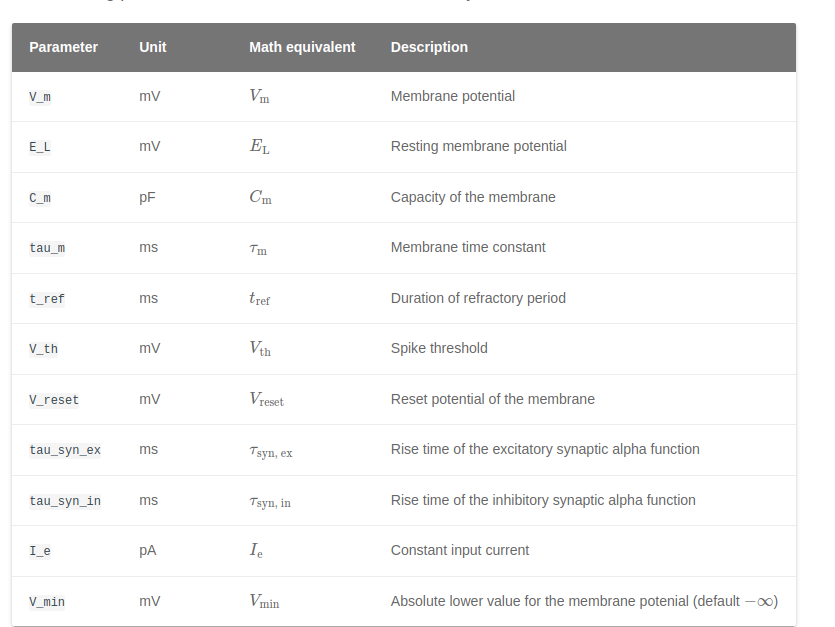

In [4]:
#Runtime
runtime = 60000

#Gamma rate
gamma_rate = 40

#Theta rate 
theta_rate = 7

#Excitatory and inhibitory global scaling factors
G_e = 10
G_i = -3

In [5]:
#Pyramidal neurons
pyr = initializations.initialize_neuron_group('iaf_psc_alpha', 206, pyr_hcamp_deco2012.params)

#Inter-neurons
inter = initializations.initialize_neuron_group('iaf_psc_alpha', 20, int_hcamp_deco2012.params)

In [6]:
#External inputs
ec_input = nest.Create('poisson_generator')
ec_input.set(rate=gamma_rate)
ec_parrot = nest.Create('parrot_neuron', n=20)
nest.Connect(ec_input, ec_parrot)

ca3_input = nest.Create('poisson_generator')
ca3_input.set(rate=gamma_rate)
ca3_parrot = nest.Create('parrot_neuron', n=20)
nest.Connect(ca3_input, ca3_parrot)

ms_input = nest.Create('poisson_generator')
ms_input.set(rate=theta_rate)
ms_parrot = nest.Create('parrot_neuron', n=10)
nest.Connect(ms_input, ms_parrot)

In [7]:
#Connection schemes
exc_conns = (
    (pyr, (pyr)),
    (ca3_parrot, (pyr, inter)),
    (ec_parrot, (pyr, inter))
)
inh_conns = (
    (inter, (pyr)),
    (ms_parrot, (inter)),
)

initializations.initialize_weights(exc_conns, inh_conns, G_e, G_i)

In [8]:
#Monitoring connections
Vm_recorder = nest.Create('multimeter')
Vm_recorder.set(record_from=['V_m'])
nest.Connect(Vm_recorder, pyr)
spike_recorder = nest.Create('spike_recorder')
nest.Connect(pyr, spike_recorder)

In [9]:
nest.Simulate(runtime)


Dec 05 14:17:50 NodeManager::prepare_nodes [Info]: 
    Preparing 281 nodes for simulation.

Dec 05 14:17:50 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 281
    Simulation time (ms): 60000
    Number of OpenMP threads: 1
    Not using MPI

Dec 05 14:18:00 SimulationManager::run [Info]: 
    Simulation finished.


Error in callback <function _draw_all_if_interactive at 0x7f025d632c00> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

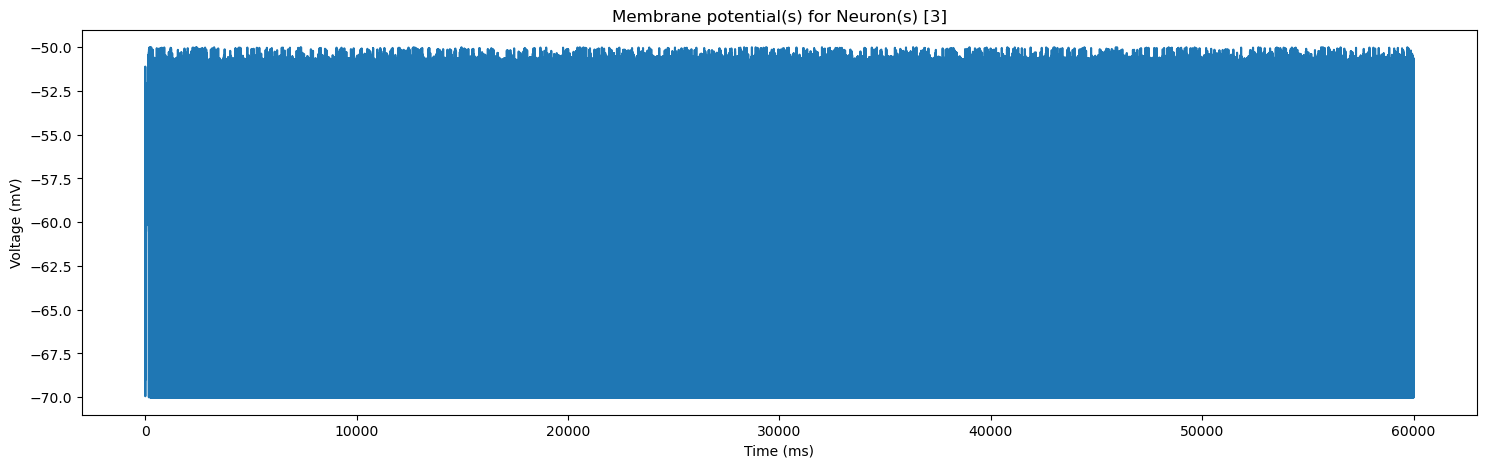

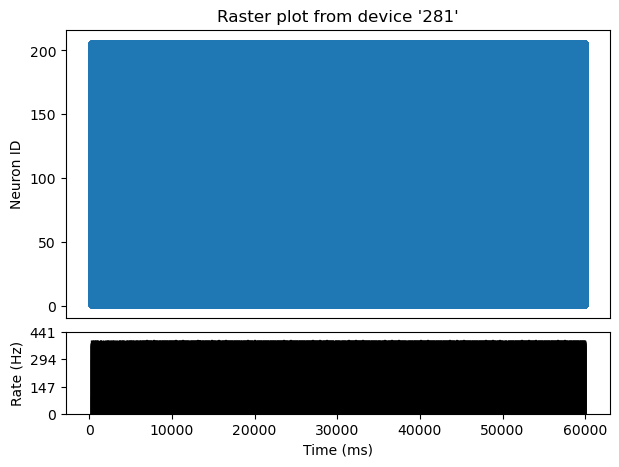

In [10]:
visualizations.plot_vms_from_device(Vm_recorder, [3])
nest.raster_plot.from_device(spike_recorder)